## Chapter9
D3.js in Actionの9章の勉強ノートです。

9章では、グラフと表を同時に表示したダッシュボックスの作成方法を説明しています。

ここでは、高岡市の地図と高岡市が公開しているオープンデータ（人口分布）を使って高岡市のダッシュボックスを作成します。


In [1]:
%load_ext sage
from IPython.core.display import HTML
from string import Template
import json
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

loaded nvd3 IPython extension
run nvd3.ipynb.initialize_javascript() to set up the notebook
help(nvd3.ipynb.initialize_javascript) for options


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 高岡市のオープンデータを取り込む


In [2]:
# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline


/usr/lib/sagemath/local/lib/python2.7/site-packages/traitlets/traitlets.py:770: DeprecationWarning: A parent of InlineBackend._config_changed has adopted the new @observe(change) API
  clsname, change_or_name), DeprecationWarning)


pandasでExcelのデータを扱えるようにするために、xlsxWriter xlrdをインストールします。また、python-nvd3も合わせてインストールします。

<pre>
$ sudo sage -sh
(sage-sh) $ pip install xlsxWriter xlrd
</pre>


In [3]:
# 高岡市のオープンデータから平成27年7月の人口データ(h270731.xlsx)を取り込みます
# 古いデータが公開リストから削除されるため、ダウンロードしたh290531.xlsxを使用するように修正しました。
# d = pd.read_excel('http://www.city.takaoka.toyama.jp/joho/shise/opendata/documents/h290531.xlsx', header=3, index_col=1)
d = pd.read_excel('data/h290531.xlsx', header=3, index_col=1)
d.head()


,頁,地区 コード,地区名,人 口,Unnamed: 4,Unnamed: 5,世帯数
NaN,NaN,NaN,NaN,男,女,計,NaN
2,NaN,01 平米地区,NaN,1514,1766,3280,1563.0
3,NaN,02 定塚地区,NaN,4370,4855,9225,4006.0
4,NaN,03 下関地区,NaN,4442,4562,9004,4022.0
5,NaN,04 博労地区,NaN,5253,5738,10991,4653.0


地区コードと地区名はセル結合していたり、頁が全てNaNになっているので、少し加工します。

In [4]:
# カラム名を付け直し、最初の5個を表示
d.columns = ['not_used', 'code', 'region', 'male', 'female', 'population', 'household']
# 最初の番号（index）が1より大きなcode, population, householdを抽出します。
d1 = d[d.index > 1][['code', 'male', 'female', 'population', 'household']]
d1.head()

,code,male,female,population,household
2,01 平米地区,1514,1766,3280,1563.0
3,02 定塚地区,4370,4855,9225,4006.0
4,03 下関地区,4442,4562,9004,4022.0
5,04 博労地区,5253,5738,10991,4653.0
6,05 横田地区,2720,2953,5673,2243.0


地区ごとの男性、女性、世帯数がどのように分布しているか、可視化してみましょう。

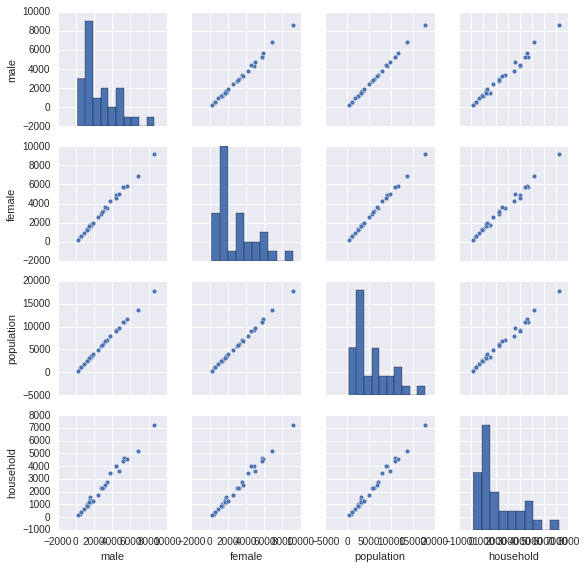

In [5]:
# 男性、女性、人口、世帯数を取り出し、ペアプロットを表示
# N：地区のindexの最大数（合計やその他のデータを除くため）
N = 35
d2 = d[d.index > 1][['male', 'female', 'population', 'household']]
d2 = d2[d2.index <=N]

sns.pairplot(d2, size=2)

### データからスプレッドシートを作る


In [6]:
%%writefile css/spreadsheet.css
div.table {
  position:relative;
}
div.data {
  position: absolute;
  width: 90px;
  padding: 0 5px;
}

div.head {
  position: absolute;
}

div.datarow {
  position: relative;
  width: 100%;
  border-top: 2px black solid;
  background: white;
  height: 25px;
  overflow: hidden;
}

.svgMap {
    float: left;    
    background: #fcfcfc;
}

.svgChart {
    display: inline-block;
    background: #fcfcfc;
}

.spreadSheet {
}

Overwriting css/spreadsheet.css


In [7]:
# データをCSVにして、D3が処理しやすいようにする
d1 = d[d.index > 1][['code', 'male', 'female', 'population', 'household']]
d2 = d1[d1.index <=N]
# 小学校区をマージ
schoolDistrictDf = pd.read_excel("data/schoolDistrict.xls")
d3 = pd.merge(d2, schoolDistrictDf, on="code", how="left")
# CSVで保存
d3.to_csv("data/d3.csv", index=False)
d3.head()

,code,male,female,population,household,schoolDistrict
0,01 平米地区,1514,1766,3280,1563.0,平米小学校
1,02 定塚地区,4370,4855,9225,4006.0,定塚小学校
2,03 下関地区,4442,4562,9004,4022.0,下関小学校
3,04 博労地区,5253,5738,10991,4653.0,博労小学校
4,05 横田地区,2720,2953,5673,2243.0,横田小学校


In [8]:
%%HTML
<!-- CSSの読み込み　-->
<link type="text/css" rel="stylesheet" href="css/spreadsheet.css" />
<script src="js/d3.geo.projection.min.js" type="text/javascript"></script>
<script src="js/colorbrewer.js" type="text/javascript"></script>
<script src="js/tile.js" type="text/javascript"></script>

<div>
    <div id="map" class="svgMap">
        <svg  style="width: 450px; height:1px;border:1px lightgray solid;" />
    </div>
    <div id="chart" class="svgChart" >
         <svg style="width:350px; height:1px;border:1px lightgray solid;"/>
    </div>
    <div  class="spreadSheet">
        <div id="spreadsheet"></div>
    <div>    
</div>


### スプレッドシートの表示
スプレッドシート（表）を表示します。

In [9]:
%%javascript
d3.csv("data/d3.csv",function(error,data) { createSpreadsheet(data, "#spreadsheet")});
      
      function createSpreadsheet(incData, target) {
        
        var keyValues = d3.keys(incData[0])
        
        d3.select(target)
        .append("div")
        .attr("class", "table")

        d3.select(target).select("div.table")
        .append("div")
        .attr("class", "head")
        .selectAll("div.data")
        .data(keyValues)
        .enter()
        .append("div")
        .attr("class", "data")
        .html(function (d) {return d})
        .style("left", function(d,i) {return (i * 100) + "px"});

        d3.select(target).select("div.table")
        .selectAll("div.datarow")
        .data(incData)
        .enter()
        .append("div")
        .attr("class", "datarow")
        .style("top", function(d,i) {return "18px"});
        
        d3.select(target).selectAll("div.datarow")
        .selectAll("div.data")
        .data(function(d) {return d3.entries(d)})
        .enter()
        .append("div")
        .attr("class", "data")
        .html(function (d) {return d.value})
        .style("left", function(d,i,j) {return (i * 100) + "px"});
      }

<IPython.core.display.Javascript object>

### 小学校区の表示
次に小学校区を表示します。

In [10]:
%%javascript
var width = 450, height = 350;
var takaokaBoundingBox = {geometry: {coordinates: [[[136.904778, 36.822525], [137.072662, 36.822525], [137.072662, 36.658552], [136.904778, 36.658552], [136.904778, 36.822525]]], type: "Polygon"}, id: 999999, properties:{}, type: "Feature"};

d3.select("#map").select("svg").attr("style", "width:450px;height:350px;border:1px lightgray solid;");
d3.select("#map").select("svg").append("g").attr("id", "tiles");
d3.select("#map").select("svg").append("g").attr("id", "vectors");

var tile = d3.geo.tile()
    .size([width, height]);

var projection = d3.geo.mercator()
    .scale((1 << 19) / 2 / Math.PI)
    .translate([width / 2, height / 2]);

var center = projection([137.025970, 36.754062]);

var path = d3.geo.path()
    .projection(projection);
var zoom = d3.behavior.zoom()
    .scale(projection.scale() * 2 * Math.PI)
    .translate([width - center[0], height - center[1]])
    .on("zoom", redraw);
d3.select("#map").select("svg").call(zoom);
projection
    .scale(1 / 2 / Math.PI)
    .translate([0, 0]);

var geoPath = d3.geo.path().projection(projection);

d3.json('data/A27-10_16-g_SchoolDistrict.json', function (schoolDistnct) {
    var data = schoolDistnct.features.filter(function(d) { 
           return  d.properties.A27_006=="高岡市立"; 
        });

    d3.select("#map").select("#vectors").selectAll("path.countries").data(data)
        .enter()
        .append("path")
        .attr("d", geoPath)
        .attr("class", "countries")
        .style("fill", "red")
        .style("stroke-width", 3)
        .style("stroke", "black")
        .style("fill-opacity", .25)   
    
});        

redraw();

function redraw() {
   var tiles = tile
        .scale(zoom.scale())
        .translate(zoom.translate())();
    
    var image = d3.select("#map").select("#tiles")
        .attr("transform",
        "scale(" + tiles.scale + ") translate(" + tiles.translate + ")")
        .selectAll("image")
        .data(tiles, function(d) { return d; });
    
    image.exit()
       .remove();

    image.enter().append("image")
        .attr("xlink:href",
         function(d) { return "http://" 
             + ["a", "b", "c"][Math.random() * 3 | 0] 
             + ".tile.openstreetmap.org/" + d[2] + "/" + d[0] + "/" + d[1] 
             + ".png"; })        
        .attr("width", 1)
        .attr("height", 1)
        .attr("x", function(d) { return d[0]; })
        .attr("y", function(d) { return d[1]; });
    
        projection
            .scale(zoom.scale() / 2 / Math.PI)
            .translate(zoom.translate());

        d3.select("#map").selectAll("path")
            .attr("d", geoPath);
}

<IPython.core.display.Javascript object>

### 円グラフの表示
次に各地域ごとの人口を円グラフで表示します。

In [11]:
%%javascript
var width = 350,
    height = 350,
    radius = Math.min(width, height) / 2;
var maxValue = 17744;
d3.select("#chart").select("svg").attr("style", "width:350px; height:350px;border:1px lightgray solid;");

var color = d3.scale.linear()
  .interpolate(d3.interpolateHcl)
  .domain([0,maxValue]).range(["yellow", "red"]);

var arc = d3.svg.arc()
    .outerRadius(radius - 10)
    .innerRadius(0);

var labelArc = d3.svg.arc()
    .outerRadius(radius - 40)
    .innerRadius(radius - 40);

var pie = d3.layout.pie()
    .value(function(d) { d.selected = false; return d.population; });

var svg = d3.select("#chart").select("svg")
    .attr("width", width)
    .attr("height", height)
    .append("g")
    .attr("transform", "translate(" + width / 2 + "," + height / 2 + ")");

d3.csv("data/d3.csv", type, function(error, data) {
  var g = svg.selectAll(".arc")
      .data(pie(data))
      .enter().append("g")
      .attr("class", "arc");

  g.append("path")
      .attr("d", arc)
      .style("stroke", "lightgray")
      .style("fill", function(d) { return color(d.data.population); });

});

function type(d) {
  d.population = +d.population;
  return d;
}

<IPython.core.display.Javascript object>

### 地図にマウスイベントを追加
地図にマウスオーバイベントを追加して、マウスの位置の小学校区と表の該当する行を青色に変えて表示します。
また、スプレッドシートが大きく画面では全て表示できないので、mouse-overイベントでその小学校区の情報を表示します。

In [12]:
%%javascript
d3.select("#vectors").selectAll("path.countries")
    .on("mouseover", hover)
    .on("mouseout", mouseOut);

var explode = function(x,index) {
  var offset = 10;
  var angle = (x.startAngle + x.endAngle) / 2;
  var xOff = Math.sin(angle)*offset;
  var yOff = -Math.cos(angle)*offset;
  return "translate("+xOff+","+yOff+")";
};

var inplode = function(x,index) {
  var offset = -0;
  var angle = (x.startAngle + x.endAngle) / 2;
  var xOff = Math.sin(angle)*offset;
  var yOff = -Math.cos(angle)*offset;
  return "translate("+xOff+","+yOff+")";
};

function hover(hoverD) {
    d3.select("#chart").selectAll("path")
        .filter( function (d) { d.data.selected =  d.data.schoolDistrict == hoverD.properties.A27_007; return d.data.selected; })
        .transition()
        .duration(500)
        .attr("transform", explode);
    d3.selectAll("div.datarow")
        .filter( function (d) { return d.schoolDistrict == hoverD.properties.A27_007})
        .style("background", "#94B8FF")
        .style("display", "block");
    d3.select("#vectors").selectAll("path.countries")
        .filter( function (d) { return d == hoverD; })
        .style("fill", "blue");
};

function mouseOut() {
    d3.select("#chart").selectAll("path")
        .filter( function (d) { return d.data.selected; })
        .transition()
        .duration(500)
        .attr("transform", inplode);
    d3.selectAll("div.datarow").style("display", "none");
    d3.select("#vectors").selectAll("path.countries").style("fill", "red");
};

<IPython.core.display.Javascript object>